In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>


# Class Reweighted Discrete Wasserstein

Consider two point clouds, $X$ with distribution $\mu$ and $Y$ with distribution $\nu$  in $\mathbb{R}^{d}$ with $X$ containing $m$ points and $Y$ containing $n$ points. Discrete optimal Transport (D-OT) seeks the coupling $P \in \mathbb{R}_{+}^{m \times n}$ between $X$ and $Y$ with minimal inner product with cost matrix $C$. Therefore, D-OT objective is:

$$\begin{equation}
    \underset{P}{\arg \min} \langle  P, C\rangle \ , \, \textit{s. t.} \ \ P \mathbf{1}_{n} = \mu \ , \   P^{\top} \mathbf{1}_{m} = \nu \ , \ P_{ij} \geq 0 \ \forall \ i,j
\end{equation}
$$

Here we modified the original OT problem and assume the data cloud $Y$ consists of multiple classes with known class label assignement for each data point in $Y$. Therefore, one can create,  0-1 Kernel $K_{Y}$ for points in $Y$,  diagonal Degree matrix $D$ with $D_{ii} = \sum_{i} K_{ij}$, and Laplacian $\mathfrak{L} = D - K$, to  modify the original D-OT as:

$$\begin{equation}
    \underset{P}{\arg \min} \langle  P, C\rangle, \  \textit{s. t.} \ \ P \mathbf{1}_{n} = \mu \ , \   D^{-1}\mathfrak{L}P^{\top} \mathbf{1}_{m} \preccurlyeq \eta \ \mathbf{1}_{n}, \ P_{ij} \geq 0 \ \forall \ i,j
\end{equation}
$$
Another Formulation of problems can be found by considering the binary 0-1 matrix A such that above 0-1 Kernel $K_{Y} = AA^{T}$. Matrix $A$ can be created by defining $j$-th column $A_{j} = (Y == j)$. Therefore one can formulate reweighted wasserstein problem by:


$$\begin{equation}
    \underset{P}{\arg \min} \langle  \tilde{P}A^{\top}, C\rangle, \  \textit{s. t.} \ \ \tilde{P}A^{\top} \mathbf{1}_{n} = \mu \ , \   D^{-1}\mathfrak{L}A\tilde{P}^{\top} \mathbf{1}_{m} \preccurlyeq \eta \ \mathbf{1}_{n}, \ \ P_{ij} \geq 0 \ \forall \ i,j
\end{equation}
$$
Since columns of $A$ are class indicators therefore $\mathfrak{L}A =0$, thereby rendering the optimization problem:


$$\begin{equation}
    \underset{P}{\arg \min} \langle  \tilde{P}A^{\top}, C\rangle, \  \textit{s. t.} \ \ \tilde{P}A^{\top} \mathbf{1}_{n} = \mu \ , \ P_{ij} \geq 0 \ \forall \ i,j
\end{equation}
$$

In the first step we create a python class to solve class reweighted wasserstein (2) and (4)

In [1]:
import numpy as np
from numpy.core.fromnumeric import squeeze
import scipy as sp
from scipy import optimize
from matplotlib import pyplot as plt
import cvxpy as cp

# Code Execution needs scipy and pycvx liberaries.
# Parts of script are taken from:
# https://nbviewer.org/github/gpeyre/numerical-tours/blob/master/python/optimaltransp_1_linprog.ipynb
'''
Class Reweighted Wasserstein Divergence
inputs: X: source data points in R^{n}
        mu: source distribution
        Y: target data points in R^{n}
        Ly: label of data points in Y
        C: cost matrix
        eta: thresholding constant
        min_tol: minimum tolerance
        max_iter: maximum number of iteraation in linear program
        solvers:  default -'scipy' : scipy's revised simplex
                            'CVX': for CVX's structured linear programming solver
                            CVX is faster and preferred choice
                 
'''
class class_reweighted_wasserstein:
    def __init__(self, X, mu, Y, Ly, eta, solver = 'scipy'):
        self.X = X
        self.mu = mu
        self.Y = Y
        self.Ly = Ly
        self.eta = eta
        self.solver = solver
    
    def execute_W2(self):
        def zero_one_kernel(Ly):
            unique_labels = np.unique(Ly)
            Z = (Ly == unique_labels) + 0.0
            return Z@Z.T
    
        def Laplacian(K):
            return np.diag(np.sum(K, axis=0)) - K
        
        def distmat(X,Y):
            return np.sum(X**2,1)[None,:] + np.sum(Y**2,1)[:,None] - 2*Y@X.T
        
        m = X.shape[0]
        n = Y.shape[0]
        
        C = distmat(self.X,self.Y).T
        Im = np.identity(m)
        In = np.identity(n)
        ones_m = np.ones((m,1))
        ones_n = np.ones((n,1))
        
        K = zero_one_kernel(self.Ly)
        invD = np.diag(1 / np.sum(K,axis = 0))
        Lap = Laplacian(K)
        
        if self.solver == 'scipy':
            vecC = C.reshape((-1,1), order = "F")
            Aeq = np.kron(ones_n.T, Im)
            beq = self.mu
            Aub = np.kron(invD@Lap, ones_m.T)
            bub = self.eta * ones_n
            Plb = 0
            Pub = 1
            res = sp.optimize.linprog(np.squeeze(vecC.T), A_eq=Aeq, b_eq=beq, A_ub=Aub, b_ub = bub, bounds = [Plb, Pub] )
            Q = res.x.reshape((n,m))
            return Q.T
        
        if self.solver  == 'CVX':
            P = cp.Variable((m,n))
            constraints = [0 <= P, cp.matmul(P,ones_n)== self.mu, cp.matmul(invD@Lap@(P.T),ones_m)<= self.eta * ones_n]
            objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
            prob = cp.Problem(objective, constraints)
            result = prob.solve()
            return P.value
    
    def execute_W2_e(self):
        
        def zero_one_class(Ly):
            unique_labels = np.unique(Ly)
            A = (Ly == unique_labels) + 0.0
            return A
        
        def distmat(X,Y):
            return np.sum(X**2,1)[None,:] + np.sum(Y**2,1)[:,None] - 2*Y@X.T
        
        def Laplacian(K):
            return np.diag(np.sum(K, axis=0)) - K
        
        m = X.shape[0]
        n = Y.shape[0]
        
        Im = np.identity(m)
        In = np.identity(n)
        ones_m = np.ones((m,1))
        ones_n = np.ones((n,1))
        
        C = distmat(self.X,self.Y).T
        A = zero_one_class(self.Ly)
        K = A@A.T
        invD = np.diag(1 / np.sum(K,axis = 0))
        Lap = Laplacian(K)
        k = A.shape[1]
        
        if self.solver == 'scipy':
            vecCr = (C@A).reshape((-1,1), order = "F")
            Aeq = np.kron(ones_n.T @ A, Im)
            beq = self.mu
            Aub = np.kron(invD@Lap@A, ones_m.T)
            bub = self.eta * ones_n
            Plb = 0
            Pub = 1
            res = sp.optimize.linprog(np.squeeze(vecCr.T), A_eq=Aeq, b_eq=beq, bounds = [Plb, Pub] )
            Q = res.x.reshape((k,m))
            return Q.T @ A.T
        
        if self.solver  == 'CVX':
            Pt = cp.Variable((m,k))
            constraints = [0 <= Pt, cp.matmul(Pt@A.T,ones_n)== self.mu]
            objective = cp.Minimize( cp.sum(cp.multiply(Pt @ A.T,C)) )
            prob = cp.Problem(objective, constraints)
            result = prob.solve()
            return Pt.value @ A.T 
 

Creating data set

In [2]:
m = 60
n = 80

In [3]:
gauss = lambda q,a,c: a*np.random.randn(2, q) + np.transpose(np.tile(c, (q,1)))
X = np.random.randn(2,m)*.3
Y = np.hstack((gauss(int(n/2),.5,[0,1.6]),np.hstack((gauss(int(n/4),.3,[-1,-1]),gauss(int(n/4),.3,[1,-1])))))
Ly = np.hstack(( 0* np.ones((1,int(n/2))), 1 * np.ones((1,int(n/4))), 2 * np.ones((1,int(n/4))))) 

X = X.T
Y = Y.T
Ly = Ly.T

eta = 1e-2

In [4]:
normalize = lambda a: a/np.sum(a)
a = normalize(np.random.rand(m, 1))
b = normalize(np.random.rand(n, 1))
mu = a

In [5]:
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*20, edgecolors="k", c=col, linewidths=2)


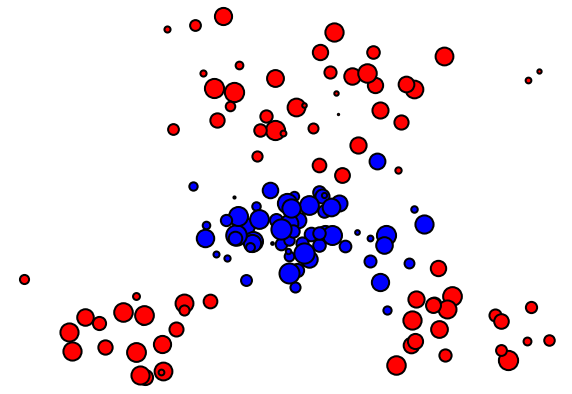

In [6]:
plt.figure(figsize = (10,7))
plt.axis("off")
for i in range(len(a)):
    myplot(X[i,0], X[i,1], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Y[j,0], Y[j,1], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Y[:,0])-.1,np.max(Y[:,0])+.1)
plt.ylim(np.min(Y[:,1])-.1,np.max(Y[:,1])+.1)
plt.show()

Solving Problem

$$\begin{equation}
    \underset{P}{\arg \min} \langle  P, C\rangle, \  \textit{s. t.} \ \ P \mathbf{1}_{n} = \mu \ , \   D^{-1}\mathfrak{L}P^{\top} \mathbf{1}_{m} \preccurlyeq \eta \ \mathbf{1}_{n}, \ P \succcurlyeq 0 \nonumber
\end{equation}
$$

In [7]:
sol = 'CVX'
test = class_reweighted_wasserstein(X, mu, Y, Ly, eta, solver = sol)
P = test.execute_W2()

In [8]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P[P>1e-5]), n + m-1))

Number of non-zero: 102 (n + m-1 = 139)


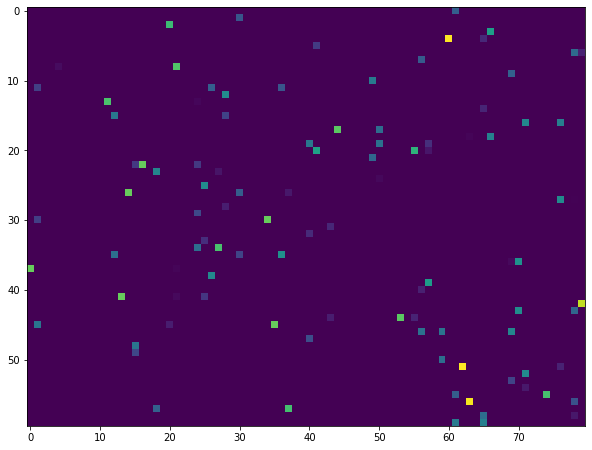

In [9]:
plt.figure(figsize = (10,10))
plt.imshow(P);

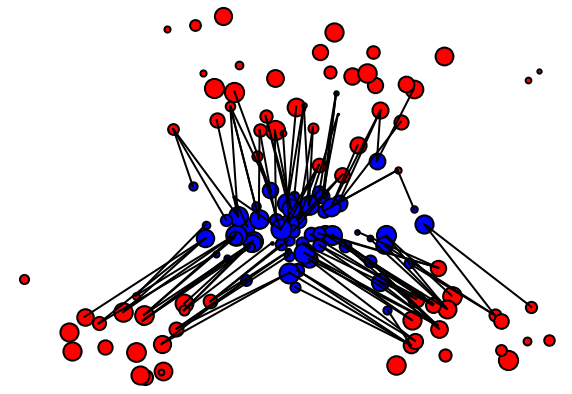

In [10]:
P[P<1e-5] = 0
I,J = np.nonzero(P)
plt.figure(figsize = (10,7))
plt.axis('off')
Xv = X.T
Yv = Y.T
for k in range(len(I)):
    h = plt.plot(np.hstack((Xv[0,I[k]],Yv[0,J[k]])),np.hstack(([Xv[1,I[k]], Yv[1,J[k]]])),'k', lw = 2)
for i in range(len(a)):
    myplot(Xv[0,i], Xv[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Yv[0,j], Yv[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Yv[0,:])-.1,np.max(Yv[0,:])+.1)
plt.ylim(np.min(Yv[1,:])-.1,np.max(Yv[1,:])+.1)
plt.show()

Solving

$$\begin{equation}
    \underset{P}{\arg \min} \langle  \tilde{P}A^{\top}, C\rangle, \  \textit{s. t.} \ \ \tilde{P}A^{\top} \mathbf{1}_{n} = \mu \ , \ P \succcurlyeq 0
\end{equation}
$$

In [12]:
sol = 'CVX'
test = class_reweighted_wasserstein(X, mu, Y, Ly, eta, solver = sol)
P1 = test.execute_W2_e()

In [13]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P1[P1>1e-5]), n + m-1))

Number of non-zero: 1540 (n + m-1 = 139)


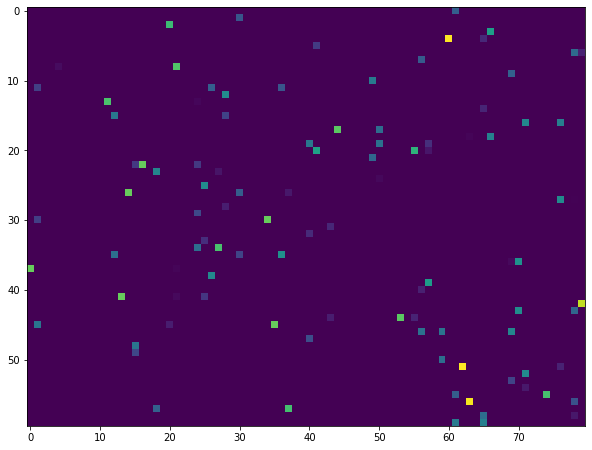

In [14]:
plt.figure(figsize = (10,10))
plt.imshow(P);

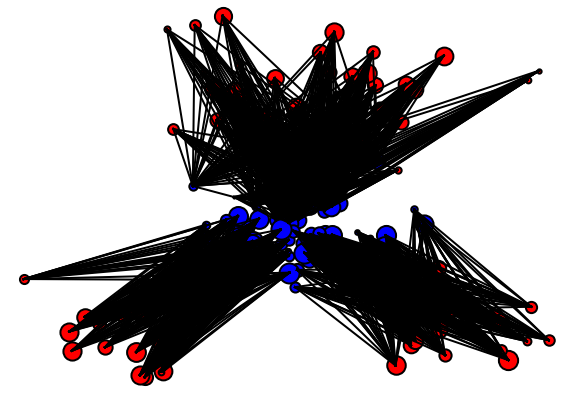

In [15]:
P1[P1<1e-5] = 0
I,J = np.nonzero(P1)
plt.figure(figsize = (10,7))
plt.axis('off')
Xv = X.T
Yv = Y.T
for k in range(len(I)):
    h = plt.plot(np.hstack((Xv[0,I[k]],Yv[0,J[k]])),np.hstack(([Xv[1,I[k]], Yv[1,J[k]]])),'k', lw = 2)
for i in range(len(a)):
    myplot(Xv[0,i], Xv[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Yv[0,j], Yv[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Yv[0,:])-.1,np.max(Yv[0,:])+.1)
plt.ylim(np.min(Yv[1,:])-.1,np.max(Yv[1,:])+.1)
plt.show()

Now solving

$$\begin{equation}
    \underset{P}{\arg \min} \langle  P, C\rangle \\ 
    \textit{s. t.} \ \ P \mathbf{1}_{n} = \mu \ , \   P^{\top} \mathbf{1}_{m} = \nu \ , \ P \succcurlyeq 0 \nonumber
\end{equation}
$$

In [16]:
def distmat(X,Y):
            return np.sum(X**2,1)[None,:] + np.sum(Y**2,1)[:,None] - 2*Y@X.T
        
m = X.shape[0]
n = Y.shape[0]

C = distmat(X,Y).T
vecC = C.reshape((-1,1), order = "F")
Im = np.identity(m)
In = np.identity(n)
ones_m = np.ones((m,1))
ones_n = np.ones((n,1))
Aeq = np.vstack((np.kron(ones_n.T, Im), np.kron(In, ones_m.T)))
beq = np.vstack((a,b))
Plb = m*n*[0]
Pub = m*n*[1]


Pu = cp.Variable((m,n))
constraints = [0 <= Pu, cp.matmul(Pu,ones_n)==1/m * ones_m, cp.matmul(Pu.T,ones_m)<= 1/n * ones_n]
objective = cp.Minimize( cp.sum(cp.multiply(Pu,C)) )
prob = cp.Problem(objective, constraints)
result = prob.solve()
# method='revised simplex'
# res = sp.optimize.linprog(np.squeeze(vecC.T), A_eq=Aeq, b_eq=beq, bounds = [0, 1], method='revised simplex')

In [17]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(Pu.value[Pu.value>1e-5]), n + m-1))

Number of non-zero: 126 (n + m-1 = 139)


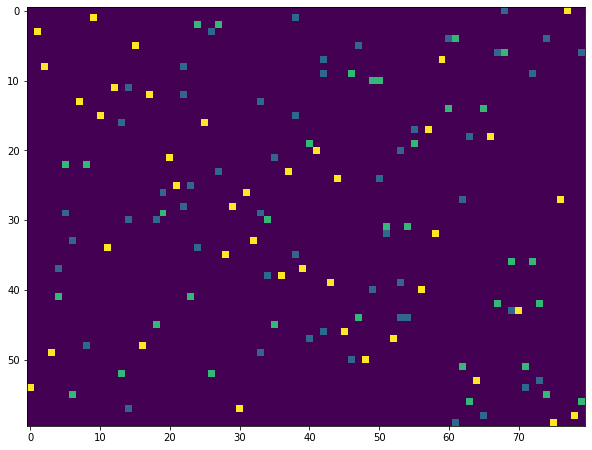

In [18]:
plt.figure(figsize = (10,10))
plt.imshow(Pu.value);

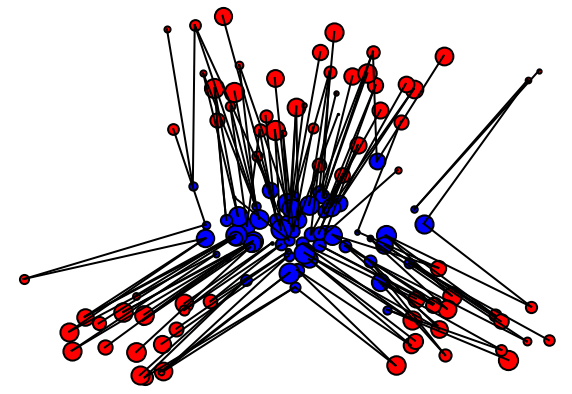

In [19]:
I,J = np.nonzero(Pu.value>1e-5)
#I,J = np.nonzero(Pu)
plt.figure(figsize = (10,7))
plt.axis('off')
Xu = X.T
Yu = Y.T
for k in range(len(I)):
    h = plt.plot(np.hstack((Xu[0,I[k]],Yu[0,J[k]])),np.hstack(([Xu[1,I[k]], Yu[1,J[k]]])),'k', lw = 2)
for i in range(len(a)):
    myplot(Xu[0,i], Xu[1,i], a[i]*len(a)*10, 'b')
for j in range(len(b)):
    myplot(Yu[0,j], Yu[1,j], b[j]*len(b)*10, 'r')
plt.xlim(np.min(Yu[0,:])-.1,np.max(Yu[0,:])+.1)
plt.ylim(np.min(Yu[1,:])-.1,np.max(Yu[1,:])+.1)
plt.show()